In [1]:
import numpy as np
import numpy.random as npr
import csv
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [2]:
from foodbornenyc.models import models as m, documents as d, businesses as b, locations as l
db = m.getDBSession()

In [3]:
%%time
bigreviews = db.query(d.YelpReview).limit(50000).all()

CPU times: user 1.62 s, sys: 232 ms, total: 1.85 s
Wall time: 1.92 s


In [4]:
sample = [rev.text for rev in np.random.choice(bigreviews, 10000, replace=False)]

In [6]:
# pull in rows and sort them by date
rows = []
with open('data/reviews_foodborne_date_biz.csv') as f:
    for i, row in enumerate(csv.reader(f)):
        if i == 0 : continue
        row[1] = int(float(row[1]))
        row[2] = datetime.datetime.strptime(row[2], '%Y-%m-%d')
        rows.append(row)

# sort by date
rows = sorted(rows, key=lambda x:x[2], reverse=True)
            
# grab first 1000 by date
data = {'X':[], 'y':[]}
for i, row in enumerate(rows):
        data['X'].append(unicode(row[0], 'utf8'))
        data['y'].append(row[1])
        if i == 2999:
            break
data['y'] = np.array(data['y'])

# grab sceond 1000 by date
testdata = {'X':[], 'y':[]}
for i, row in enumerate(rows[3000:]):
        testdata['X'].append(row[0])
        testdata['y'].append(row[1])
        #if i == 1000:
        #    break
testdata['y'] = np.array(testdata['y'])

In [7]:
data['X'].extend(sample)
data['y'] = np.append(data['y'], np.zeros(len(sample)))
print len(data['X'])
print data['y'].shape

13000
(13000,)


In [8]:
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
folds = cross_validation.StratifiedKFold(data['y'], n_folds=3, random_state=0, shuffle=True)

In [10]:
from sklearn import metrics

def my_roc_auc(ground_truth, predictions):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    return metrics.roc_auc_score(ground_truth, predictions, average='micro')

my_roc_auc_scorer = metrics.make_scorer(my_roc_auc, needs_threshold=True, greater_is_better=True)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
# define baseline pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer



# Feature Extractors
cv = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents='unicode', 
        lowercase=True,
        analyzer=u'word', 
        preprocessor=None, 
        tokenizer=None, 
        stop_words='english', 
        #token_pattern=u'(?u)\\b\w\w+\b', # one alphanumeric is a token
        ngram_range=(1, 2), 
        max_df=.9, 
        min_df=2, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        #dtype=type 'numpy.int64'>
        )
from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer(
        norm='l2',
        use_idf=True,
        smooth_idf=True,
        sublinear_tf=False
)

# Final Classifier
from sklearn.naive_bayes import MultinomialNB
lr = LogisticRegression(C=.05,
                        fit_intercept=True,
                        random_state=0,
                        class_weight='balanced',
                        n_jobs=-1)

pipeline = Pipeline([
    ('count', cv),
    ('tfidf', tf),
    ('logreg', lr)
    ])

param_grid = {
    'count__ngram_range':[(1,1),(1,2),(1,3)],
    'tfidf__norm':['l1', 'l2'],
    'tfidf__use_idf':[True, False],
    'tfidf__sublinear_tf':[True,False],
    'logreg__C':[.001, .01, .1]
}

In [15]:
from sklearn.grid_search import GridSearchCV
grid_search = GridSearchCV(pipeline, 
                           param_grid,
                           cv = folds,
                           scoring=my_roc_auc_scorer,
                           n_jobs=-1, verbose=1)

In [16]:
grid_search.fit(np.array(data['X']), data['y'])
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  6.5min finished


()
Best score: 0.975
Best parameters set:
	count__ngram_range: (1, 2)
	logreg__C: 0.1
	tfidf__norm: 'l2'
	tfidf__sublinear_tf: True
	tfidf__use_idf: True


(array([  2.,   4.,   6.,   7.,   3.,   3.,   3.,   7.,  19.,  18.]),
 array([ 0.91587056,  0.9218031 ,  0.92773563,  0.93366817,  0.9396007 ,
         0.94553324,  0.95146577,  0.95739831,  0.96333084,  0.96926338,
         0.97519592]),
 <a list of 10 Patch objects>)

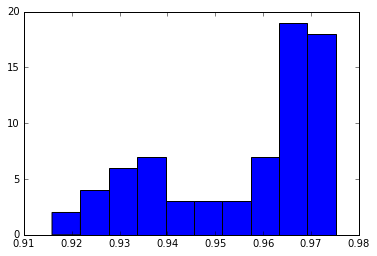

In [17]:
scores = [s.mean_validation_score for s in grid_search.grid_scores_]
plt.hist(scores)

In [18]:
# output the best one
from sklearn.externals import joblib
from foodbornenyc.settings import yelp_classify_config as config
joblib.dump(grid_search.best_estimator_, '../'+config['model_file']) 

['../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_01.npy',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_02.npy',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_03.npy',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_04.npy',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_05.npy',
 '../foodbornenyc/pipelines/models/yelp_sick_logreg.pkl_06.npy']

### Now load it from file

In [1]:
from sklearn.externals import joblib
from foodbornenyc.settings import yelp_classify_config as config

sick = joblib.load("../"+config['model_file'])

In [2]:
from foodbornenyc.models.models import getDBSession
from foodbornenyc.models.documents import YelpReview, yelp_reviews


In [3]:
db = getDBSession(echo=True)

In [4]:
print yelp_reviews.columns

['yelp_reviews.id', 'yelp_reviews.doc_assoc_id', 'yelp_reviews.text', 'yelp_reviews.rating', 'yelp_reviews.user_name', 'yelp_reviews.created', 'yelp_reviews.updated_at', 'yelp_reviews.business_id']


In [18]:
reviews = db.query(YelpReview)[:1000]

2016-02-01 12:51:49,394 INFO sqlalchemy.engine.base.Engine SELECT anon_1.yelp_reviews_id AS anon_1_yelp_reviews_id, anon_1.yelp_reviews_doc_assoc_id AS anon_1_yelp_reviews_doc_assoc_id, anon_1.yelp_reviews_text AS anon_1_yelp_reviews_text, anon_1.yelp_reviews_rating AS anon_1_yelp_reviews_rating, anon_1.yelp_reviews_user_name AS anon_1_yelp_reviews_user_name, anon_1.yelp_reviews_created AS anon_1_yelp_reviews_created, anon_1.yelp_reviews_updated_at AS anon_1_yelp_reviews_updated_at, anon_1.yelp_reviews_business_id AS anon_1_yelp_reviews_business_id, documents_1.inc_pred AS documents_1_inc_pred, documents_1.inc_label AS documents_1_inc_label, documents_1.fp_pred AS documents_1_fp_pred, documents_1.mult_pred AS documents_1_mult_pred, documents_1.mult_pred_time AS documents_1_mult_pred_time, documents_1.inc_label_time AS documents_1_inc_label_time, documents_1.fp_pred_time AS documents_1_fp_pred_time, documents_1.fp_label_time AS documents_1_fp_label_time, documents_1.mult_label AS docume

INFO:sqlalchemy.engine.base.Engine:SELECT anon_1.yelp_reviews_id AS anon_1_yelp_reviews_id, anon_1.yelp_reviews_doc_assoc_id AS anon_1_yelp_reviews_doc_assoc_id, anon_1.yelp_reviews_text AS anon_1_yelp_reviews_text, anon_1.yelp_reviews_rating AS anon_1_yelp_reviews_rating, anon_1.yelp_reviews_user_name AS anon_1_yelp_reviews_user_name, anon_1.yelp_reviews_created AS anon_1_yelp_reviews_created, anon_1.yelp_reviews_updated_at AS anon_1_yelp_reviews_updated_at, anon_1.yelp_reviews_business_id AS anon_1_yelp_reviews_business_id, documents_1.inc_pred AS documents_1_inc_pred, documents_1.inc_label AS documents_1_inc_label, documents_1.fp_pred AS documents_1_fp_pred, documents_1.mult_pred AS documents_1_mult_pred, documents_1.mult_pred_time AS documents_1_mult_pred_time, documents_1.inc_label_time AS documents_1_inc_label_time, documents_1.fp_pred_time AS documents_1_fp_pred_time, documents_1.fp_label_time AS documents_1_fp_label_time, documents_1.mult_label AS documents_1_mult_label, docume

2016-02-01 12:51:49,395 INFO sqlalchemy.engine.base.Engine {}


INFO:sqlalchemy.engine.base.Engine:{}


In [19]:
text = [rev.text for rev in reviews]

In [20]:
from time import time
start = time()
for rev in reviews:
    print rev.document.id
print "TIME:", time() - start

---_gIHr8LqJcZcuy7m5qQ
---ZRiq9CXMkiF1h7GnYHA
--_egyROzzglniNu4v7hzA
--_hceLrSFEjkAjeI6NIkw
--07Yf2eaLPloKzeN3nahg
--2hFzwRM4lp0yZHDo7pPA
--4_p6Z3tKadJcr9Non_Vw
--4dF690A6n7wEBX2ClSPQ
--4ZeOLUj8XU86mUFFJMTA
--5gUPR71nV_RsDmUV85tQ
--7XhLEQmwU6T8FvlJMCIQ
--8_qLUCQ-AjjbRm26gp3Q
--83LhfASkS0SRjJKGUUJg
--85a9TTS_02dsHq7gyKtA
--8L32Z8Fu2Go84ELQ_pSA
--9No8HnBkepddZcNz8t2w
--aBKNi8GN28DyI0Sgk5cg
--AF9dHZERQNnT1t9TKP_A
--aGr0goDeZpQWWmmsrRMw
--Al1VYjHegnOfTVotCHFw
--bKyJBSlArlvPMpsW-cdA
--bw17FuLWDFWkXQAu3kXw
--CJYQ4jdg7j3lKBiGAAvw
--CLNoIkilcA277pV8ysLw
--cyK6iRvmGeG-NrIKsWTw
--d0zSG2lJABk6zMcnbQHg
--dBPPkPm-thZalItf9tPQ
--dcchQCerm7gqfpKlZqTg
--dra1eaNe5efXYfSqA_BA
--Dt78Wp0dDBbwnGb_CPAg
--dtIbFLpVCC8RCVe16aKQ
--E6oG_0TxbIFiyXabIHiQ
--EaNQ7Pwq8eFfW0SzOhAQ
--GFzQulIFYJKMt3JL2YSQ
--gJkxbsiSIwsQKbiwm_Ng
--gU7hCjvgErsowZbGL8EQ
--hgKLR6Ew2C-cVfwYniZQ
--igQ_icD9GRh7kX0LbEiw
--JgnIGC1XdpaEo6_l7Q3g
--LniqaYWSKCMMrlaFHpFQ
--M-2z0T98nwNX4UH5NQIg
--Mavgpi8BIlc4PaecLSow
--Mghr8QgTTvuJ4HhVEmhw
--MWCZ4HAFs

### Notes on associative loading strategies:

Loading the Documents of 10 YelpReviews
- Lazy (select): > 9 sec
- Eager (joined):> .0005 sec
- Eager (subquery): > 10 sec

 These don't seem to be working any differently really.  The whole point is that document should be getting queried on the the load YelpReivews above
 
**Correct way:** The relationship from YelpReview to DocAssoc and from DocAssoc to Document need to both be same type of eager

Time for 1000 = 0.013 sec -- now that's much better

In [21]:
scores = sick.predict_proba(text)

In [22]:
print scores

[[ 0.75584242  0.24415758]
 [ 0.77928709  0.22071291]
 [ 0.68264624  0.31735376]
 ..., 
 [ 0.67613724  0.32386276]
 [ 0.72058445  0.27941555]
 [ 0.78891708  0.21108292]]


In [23]:
for s, t in sorted(zip(scores[:,1], text), key=lambda x:x[0], reverse=True):
    print s, t
    print

0.590433105407 I met with a friend here for dinner.  This place was packed and I could barely hear my friend whom I had not seen in months!  (Sad face.)  

Further the food made me so sick that I had to end our evening early and go home.   (Angry face.)

Eat here at your own risk...

0.550744564957 We had a very disappointing experience at Charlie Palmer Steak. They probably would have gotten another star if the expectations (and prices) hadn't been so high. They probably would have gotten one fewer star had they not given us free desserts. Let's start with the service; just the facts:
Arrival - 7:32 pm
First Course - 8:49 pm
Main Course - 9:45 pm
And the server re-checked my order twice.
I don't know if they were understaffed or what, but the place was not super busy.

Oh, and they put us at a table that was too small for our party size.

Oh, and it was crazy loud when we got there. Died down when everybody else left.

The food...

Look, the food wasn't terrible. Nobody got food poiso

In [24]:
import matplotlib.pyplot as plt
% matplotlib inline

(array([  3.,   1.,   2.,   1.,   3.,   1.,   5.,   3.,   7.,   4.,   6.,
          9.,   9.,  17.,  15.,  20.,  14.,  22.,  21.,  29.,  25.,  23.,
         29.,  27.,  32.,  25.,  25.,  34.,  42.,  35.,  24.,  26.,  24.,
         22.,  22.,  21.,  20.,  17.,  21.,  22.,  18.,  11.,  17.,  17.,
         16.,  15.,  18.,  16.,  11.,  14.,  11.,   9.,   5.,   7.,  10.,
          8.,   9.,   6.,   6.,   3.,   6.,   6.,   4.,   3.,   7.,   3.,
          3.,   4.,   5.,   1.,   1.,   5.,   5.,   2.,   1.,   2.,   0.,
          0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 0.15337688,  0.15774744,  0.162118  ,  0.16648857,  0.17085913,
         0.17522969,  0.17960025,  0.18397082,  0.18834138,  0.19271194,
         0.1970825 ,  0.20145306,  0.20582363,  0.21019419,  0.21456475,
         0.21893531,  0.22330588,  0.22767644,  0.232047  ,  0.23641756,
         0.24078812,  0.24

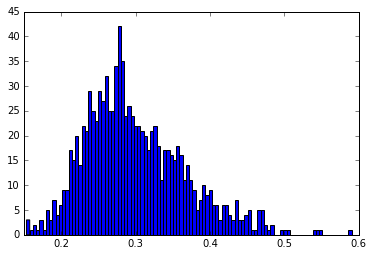

In [25]:
plt.hist(scores[:,1], 100)

In [26]:
from foodbornenyc.methods import yelp_classify

In [27]:
clf = yelp_classify.YelpClassify('../'+config['model_file'])

In [32]:
% time
for rev in reviews:
    rev = clf.score_review(rev)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


In [33]:
other_scores = [rev.document.fp_pred for rev in reviews]
print other_scores

[0.24415758450327996, 0.22071291045322933, 0.31735376184117386, 0.22220846145802492, 0.25106927948043695, 0.27554406913247947, 0.24335276623550417, 0.23389829933549194, 0.35485630078820724, 0.24828741141377872, 0.34039241655515351, 0.3902590448422274, 0.35208686415663182, 0.42274469107393592, 0.24652932168460059, 0.26382113905754384, 0.43495967566169041, 0.29575350330643535, 0.20616789825919721, 0.18901445812106024, 0.24162016787227544, 0.33240450896465806, 0.42499756215273005, 0.32339108935314037, 0.28811494602539922, 0.3475597231631562, 0.24491481360538969, 0.35092082042213324, 0.38658098335403634, 0.34199740589428657, 0.26303592757780259, 0.43340331916327601, 0.32506179003935837, 0.24029001760337931, 0.2659183944476417, 0.26767271141647814, 0.40209456977724517, 0.29635360653626752, 0.27569860391789325, 0.35119208020089954, 0.44549010456272364, 0.35721907427006494, 0.2779700862380286, 0.20916595563829329, 0.33784711466030776, 0.54626332735189909, 0.2740646027660657, 0.410967261603080

(array([  3.,   1.,   2.,   1.,   3.,   1.,   5.,   3.,   7.,   4.,   6.,
          9.,   9.,  17.,  15.,  20.,  14.,  22.,  21.,  29.,  25.,  23.,
         29.,  27.,  32.,  25.,  25.,  34.,  42.,  35.,  24.,  26.,  24.,
         22.,  22.,  21.,  20.,  17.,  21.,  22.,  18.,  11.,  17.,  17.,
         16.,  15.,  18.,  16.,  11.,  14.,  11.,   9.,   5.,   7.,  10.,
          8.,   9.,   6.,   6.,   3.,   6.,   6.,   4.,   3.,   7.,   3.,
          3.,   4.,   5.,   1.,   1.,   5.,   5.,   2.,   1.,   2.,   0.,
          0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 0.15337688,  0.15774744,  0.162118  ,  0.16648857,  0.17085913,
         0.17522969,  0.17960025,  0.18397082,  0.18834138,  0.19271194,
         0.1970825 ,  0.20145306,  0.20582363,  0.21019419,  0.21456475,
         0.21893531,  0.22330588,  0.22767644,  0.232047  ,  0.23641756,
         0.24078812,  0.24

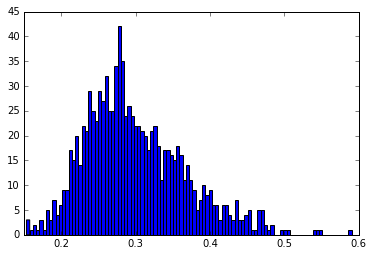

In [34]:
plt.hist(other_scores, 100)

## Yay it works!

Intended restart point below

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

from foodbornenyc.methods import yelp_classify
from foodbornenyc.settings import yelp_classify_config as config

DEBUG:root:test


In [2]:
clf = yelp_classify.YelpClassify('../'+config['model_file'])

In [ ]:
clf.classify_reviews(verbose=True, since=1)

DEBUG:root:test
